In [1]:
import random
import datetime
import time
import tqdm
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    make_scorer, mean_squared_log_error, root_mean_squared_error, 
    classification_report, 
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_docs.vis import embed
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B1, EfficientNetV2B3, MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_addons as tfa

import imageio

import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk

from IPython import display
from urllib import request

import matplotlib.pyplot as plt


from pathlib import Path

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

Using device: GPU


## Constants

In [2]:
SEED = 476
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [3]:
exp_name  = time.strftime("%m_%d_%Y_%H_%M", time.localtime())
exp_name

'05_20_2025_15_08'

In [4]:
# Pathing
video_dir = "../Videos"
annotations_dir = "../Annotations"
extracted_dir = "../ExtractedFrames"
multi_label_dir = "../MultiLabelFrames"
detections_path = "../Detections"
chekpoint_path = "../mentett_model"

filtered_path = os.path.join(multi_label_dir, "labels_filtered.csv")
labels_csv_path = os.path.join(multi_label_dir,"labels.csv")

In [5]:
model_path = f"../mentett_model/full_pipeline_best_val_recall_05_19_2025_15_51.keras"

In [6]:
os.makedirs(extracted_dir, exist_ok=True)
os.makedirs(multi_label_dir, exist_ok=True)

# Osztályok listája "timestamp" kivételével
with open(os.path.join(annotations_dir, 
                       os.listdir(annotations_dir)[0]), 'r') as f:
    header = f.readline().strip().split(',')
    
    COLUMNS = [col for col in header if col != 'timestamp']

## Model parameters

In [7]:
# Data parameters
create_data = False

img_size = 224
num_classes = len(os.listdir("../ExtractedFrames")) #49

timestep = 0.5
FRAMES_PER_TIMESTAMP = 3

DATA_AUTOTUNE = tf.data.AUTOTUNE

buffer_size = 1000

# Model Hyperparameters
batch_size = 64
epochs = 20
learning_rate = 5e-5

criterion = tf.keras.losses.BinaryCrossentropy()
activation_func = tf.keras.activations.gelu
dense_initializer = tf.keras.initializers.HeNormal(SEED)

classiormalhreshold = 0.3


In [8]:
def scheduler(epoch, lr):
    if epoch < 550:
        return lr
    else:
        return lr * np.exp(-0.1)

In [9]:
# Annotations
class_names = ["timestamp","30","50","60","70","elozniTilos",
               "keresztezodesAlarendeltUttal","foutvonal",
               "elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIrany",
               "kerulesiIranyJobbra","kerulesiIranyBalra",
               "korforgalom","40","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "utszukulet","zsakutca","gyalogosok",
               "varakozniTilos","megallniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano","nincs"]

class_names_annotations = [
                "30","50","60","70","elozniTilos",
               "keresztezodesAlarendeltUttal","foutvonal",
               "elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIrany",
               "kerulesiIranyJobbra","kerulesiIranyBalra",
               "korforgalom","40","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "utszukulet","zsakutca","gyalogosok",
               "varakozniTilos","megallniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano","nincs"]

print(len(class_names))
print(len(class_names_annotations))

51
50


In [ ]:
# Creat new CSV files for new videos

if create_data:
    sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
    header = pd.read_csv(sample_csv, nrows=1).columns.tolist()

    created_files = []

    for fname in sorted(os.listdir(video_dir)):
        if not fname.endswith(".mp4"):
            continue

        base = os.path.splitext(fname)[0]
        csv_path = os.path.join(annotations_dir, f"{base}.csv")

        if os.path.exists(csv_path):
            continue

        video_path = os.path.join(video_dir, fname)
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps
        cap.release()

        timestamps = [round(i * 0.5, 1) for i in range(int(duration / 0.5))]

        df = pd.DataFrame(columns=header)
        df["timestamp"] = timestamps
        for col in header:
            if col != "timestamp":
                df[col] = 0

        df.to_csv(csv_path, index=False)
        created_files.append(csv_path)

    print(f"{len(created_files)} new CSV file created.")


0 new CSV file created.


In [10]:
# Annotations for video files
video_filenames = glob.glob(video_dir + "*.mp4")

for filename in video_filenames:
    base = os.path.basename(filename)
    name = base[:-4]  # pl. 0001
    csv_path = annotations_dir + f"{name}.csv"
    
    # Dont overwrite existing columns
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        for col in class_names:
            if col not in df_existing.columns:
                df_existing[col] = 0
        df_existing.to_csv(csv_path, index=False)
    # Add new column
    else:
        df = pd.DataFrame(
            data=np.zeros((1000, len(class_names)), dtype=int),
            columns=class_names)
        df["timestamp"] = [x/2 for x in range(0, 1000)]
        df.to_csv(csv_path, index=False)


In [93]:
# Add "nincs" column
for file in os.listdir(annotations_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(annotations_dir, file))
        df["nincs"] = (df[COLUMNS].sum(axis=1) == 0).astype(int)
        df.to_csv(os.path.join(annotations_dir, file), index=False)

In [21]:
# Column "nincs" update to 1 wheres no sign

for filename in os.listdir(annotations_dir):
    if not filename.endswith(".csv"):
        continue

    path = os.path.join(annotations_dir, filename)
    df = pd.read_csv(path)

    label_columns = [col for col in df.columns if col not in ["timestamp", "nincs"]]

    df["nincs"] = (df[label_columns].sum(axis=1) == 0).astype(int)

    df.to_csv(path, index=False)

print("'nincs' column updated")

'nincs' column updated


In [ ]:
# Utility for managing columns

for filename in os.listdir(annotations_dir):
    if filename.endswith(".csv"):
        path = os.path.join(annotations_dir, filename)
        df = pd.read_csv(path)

        # Keeps required columns, if missing, add with 0
        for col in class_names:
            if col not in df.columns:
                df[col] = 0
        # Only selected columns
        df = df[[col for col in class_names if col in df.columns]]

        df.to_csv(path, index=False)

print("New columns from 'class_names' added")


New columns from 'class_names' added


In [24]:
# Fix "timestamp" column's values

timestep = 0.5

for filename in os.listdir(annotations_dir):
    if not filename.endswith(".csv"):
        continue

    csv_path = os.path.join(annotations_dir, filename)
    df = pd.read_csv(csv_path)

    df["timestamp"] = [round(i * timestep, 2) for i in range(len(df))]

    df.to_csv(csv_path, index=False)

print("Timestamp fixed")


Timestamp fixed


In [ ]:
# Annotation user interface
class VideoAnnotator:
    """Utility class for easy annotation."""
    def __init__(self, root):
        self.root = root
        self.root.title("Road sign annotator.")

        self.video_files = sorted(f for f in os.listdir(video_dir) if f.endswith(".mp4"))
        self.current_index = 291

        self.canvas = tk.Canvas(root, width=1440, height=810)
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.var_dict = {name: tk.IntVar() for name in class_names_annotations}
        self.check_frame = tk.Frame(root)
        self.check_frame.grid(row=1, column=0, columnspan=3)

        for i, name in enumerate(class_names_annotations):
            cb = tk.Checkbutton(self.check_frame, text=name, variable=self.var_dict[name])
            cb.grid(row=i//10, column=i%10, sticky='w')

        self.time_label = tk.Label(root, text="Time: 0.0s")
        self.time_label.grid(row=2, column=0)

        self.video_label = tk.Label(root, text="Video: " + self.video_files[self.current_index])
        self.video_label.grid(row=3, column=0, columnspan=3)

        self.prev_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.prev_btn.grid(row=2, column=1)

        self.next_btn = tk.Button(root, text=">> Next", command=self.next_frame)
        self.next_btn.grid(row=2, column=2)

        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

        self._load_video()

        self.bind_keys()

        self.root.bind("<Right>", lambda event: self.next_video())

    def _load_video(self):
        video_file = self.video_files[self.current_index]
        self.cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        _csv_path = os.path.join(annotations_dir, video_file.replace(".mp4", ".csv"))
        self.df = pd.read_csv(_csv_path)

        self.df["timestamp"] = self.df["timestamp"].astype(float)

        self.frame_index = 0
        self._update_frame()

        


    def _update_frame(self):
        timestamp = self.df.iloc[self.frame_index]['timestamp']
        self.time_label.config(text=f"Time stamp: {timestamp:.1f}s")
        frame_number = int(timestamp * self.fps)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.resize(frame, (1440, 810))
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            imgtk = ImageTk.PhotoImage(image=img)
            self.canvas.imgtk = imgtk
            self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        for name in class_names_annotations:
            self.var_dict[name].set(int(self.df.iloc[self.frame_index].get(name, 0)))

    def save_frame(self):
        for name in class_names_annotations:
            #self.df.at[self.frame_index, name] = self.var_dict[name].get()
            self.df.loc[self.frame_index, name] = self.var_dict[name].get()


    def next_frame(self):
        self.save_frame()
        if self.frame_index + 1 < len(self.df):
            self.frame_index += 1
            self._update_frame()
        else:
            self.save_csv()
            messagebox.showinfo("Video Done.")

    def prev_frame(self):
        self.save_frame()
        if self.frame_index > 0:
            self.frame_index -= 1
            self._update_frame()

    def save_csv(self):
        video_file = self.video_files[self.current_index]
        csv_path = os.path.join(
            annotations_dir, video_file.replace(".mp4", ".csv")
        )
        #self.df.to_csv(csv_path, index=False)
        self.df.to_csv(csv_path, index=False, float_format="%.1f")


    def on_closing(self):
        self.save_frame()
        self.save_csv()
        self.root.destroy()
    
    def bind_keys(self):
        self.root.bind("<d>", lambda event: self.next_frame())
        self.root.bind("<a>", lambda event: self.prev_frame())
    
    def next_video(self):
        self.save_frame()
        self.save_csv()

        if self.current_index + 1 < len(self.video_files):
            self.current_index += 1
            self._load_video()
            self.video_label.config(text="Video: " + self.video_files[self.current_index])
        else:
            messagebox.showinfo("Vége", "Nincs több videó.")



print("Easy annotation creator loaded")


Easy annotation creator loaded


In [ ]:
# Launch the User Interface for annotation
root = tk.Tk()
app = VideoAnnotator(root)
root.mainloop()

In [ ]:
# Delete '_nincs.jpg' from labels.csv

deleted_count = 0

for fname in os.listdir(multi_label_dir):
    if fname.endswith("_nincs.jpg"):
        path = os.path.join(multi_label_dir, fname)
        os.remove(path)
        deleted_count += 1

print(f"Törölve: {deleted_count} _nincs.jpg fájl")


Törölve: 0 _nincs.jpg fájl


In [ ]:
# Functions to filter out bad quality images

def is_low_contrast(image, threshold=30):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    stddev = np.std(gray)
    return stddev < threshold

def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

In [ ]:
# Save 5000 images where there are no traffic sign

IMG_SIZE = (512, 512)
nincs_limit = 5000
nincs_counter = 0
TABLA_BUFFER = 3.0

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns.tolist()
COLUMNS = [col for col in header if col != 'timestamp']

file_records = []

print("Processing filtered _nincs.jpg frames...")

for video_file in tqdm(sorted(os.listdir(video_dir))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(video_dir, video_file)
    csv_path = os.path.join(annotations_dir, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    tabla_timestamps = df[df[COLUMNS].drop(columns=["nincs"]).sum(axis=1) > 0]["timestamp"].values

    for i, row in df.iterrows():
        timestamp = row['timestamp']
        center_frame = int(timestamp * fps)

        # Skip if frame would be outside video
        if center_frame >= frame_count:
            continue

        if row['nincs'] == 1 and i % 2 == 0 and nincs_counter < nincs_limit:
            if any(abs(timestamp - t) <= TABLA_BUFFER for t in tabla_timestamps):
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, center_frame)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMG_SIZE)

            if is_blurry(resized) or is_low_contrast(resized):
                continue

            filename = f"{base_name}_{timestamp:.1f}_{center_frame}_nincs.jpg"
            filepath = os.path.join(multi_label_dir, filename)
            cv2.imwrite(filepath, resized)

            label_vector = [0 if col != 'nincs' else 1 for col in COLUMNS]
            file_records.append([filename] + label_vector)
            nincs_counter += 1

    cap.release()

# Save and don't overwrite labels.csv's existing lines
labels_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)

if os.path.exists(labels_csv_path):
    existing_df = pd.read_csv(labels_csv_path)
    labels_df = pd.concat([existing_df, labels_df], ignore_index=True)

labels_df.to_csv(labels_csv_path, index=False)
print(f"Done: {len(labels_df)} quality _nincs.jpg saved.")


Processing filtered _nincs.jpg frames...


100%|██████████| 299/299 [05:54<00:00,  1.19s/it]


Done: 5000 quality _nincs.jpg saved.


In [ ]:
# Save all images where there are at least 1 traffic sign is seen

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns.tolist()
COLUMNS = [col for col in header if col != 'timestamp']

file_records = []

print("Processing filtered images with signs...")

for video_file in tqdm(sorted(os.listdir(video_dir))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(video_dir, video_file)
    csv_path = os.path.join(annotations_dir, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _, row in df.iterrows():
        timestamp = row['timestamp']
        center_frame = int(timestamp * fps)

        if row['nincs'] == 1:
            continue

        active_labels = [label for label in COLUMNS if row[label] == 1]
        offsets = [-1, 0, 1]

        for offset in offsets:
            frame_num = center_frame + offset
            if frame_num < 0 or frame_num >= frame_count:
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMG_SIZE)

            if is_blurry(resized) or is_low_contrast(resized):
                continue

            filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
            filepath = os.path.join(multi_label_dir, filename)
            cv2.imwrite(filepath, resized)

            label_vector = [int(label in active_labels) for label in COLUMNS]
            file_records.append([filename] + label_vector)

    cap.release()

# Mentés
labels_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)

if os.path.exists(labels_csv_path):
    existing_df = pd.read_csv(labels_csv_path)
    labels_df = pd.concat([existing_df, labels_df], ignore_index=True)

labels_df.to_csv(labels_csv_path, index=False)
print(f"Done: {len(labels_df)} quality images with signs saved.")


Processing filtered images with signs...


100%|██████████| 299/299 [52:28<00:00, 10.53s/it]  


Done: 24579 quality images with signs saved.


In [32]:
# Add 'nincs' colum, and remake labels.csv

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns
label_columns = [col for col in header if col != "timestamp"]

records = []

for fname in os.listdir(multi_label_dir):
    if not fname.endswith(".jpg"):
        continue

    parts = fname.split("_")
    base_name = parts[0]
    csv_file = os.path.join(annotations_dir, base_name + ".csv")

    if not os.path.exists(csv_file):
        continue

    df = pd.read_csv(csv_file)

    timestamp = float(parts[1])
    row = df[df["timestamp"] == timestamp]

    if row.empty:
        continue

    label_row = row[label_columns].iloc[0].to_list()
    records.append([fname] + label_row)

labels_df = pd.DataFrame(records, columns=["filename"] + label_columns)
labels_df.to_csv(labels_csv_path, index=False)

print("New 'labels.csv' generated, with 'nincs' column")


KeyboardInterrupt: 

In [ ]:
# Generate new 'labels_filtered.csv'
# Max 2 signs on a picture

labels_df = pd.read_csv(labels_csv_path)

label_cols = [col for col in labels_df.columns if col not in ["filename", "nincs"]]

labels_df["num_signs"] = labels_df[label_cols].sum(axis=1)

filtered_df = labels_df[labels_df["num_signs"] < 3].drop(columns=["num_signs"])

filtered_df.to_csv(filtered_path, index=False)
print(f"labels_filtered.csv created: {len(filtered_df)} line")


labels_filtered.csv created: 22542 line


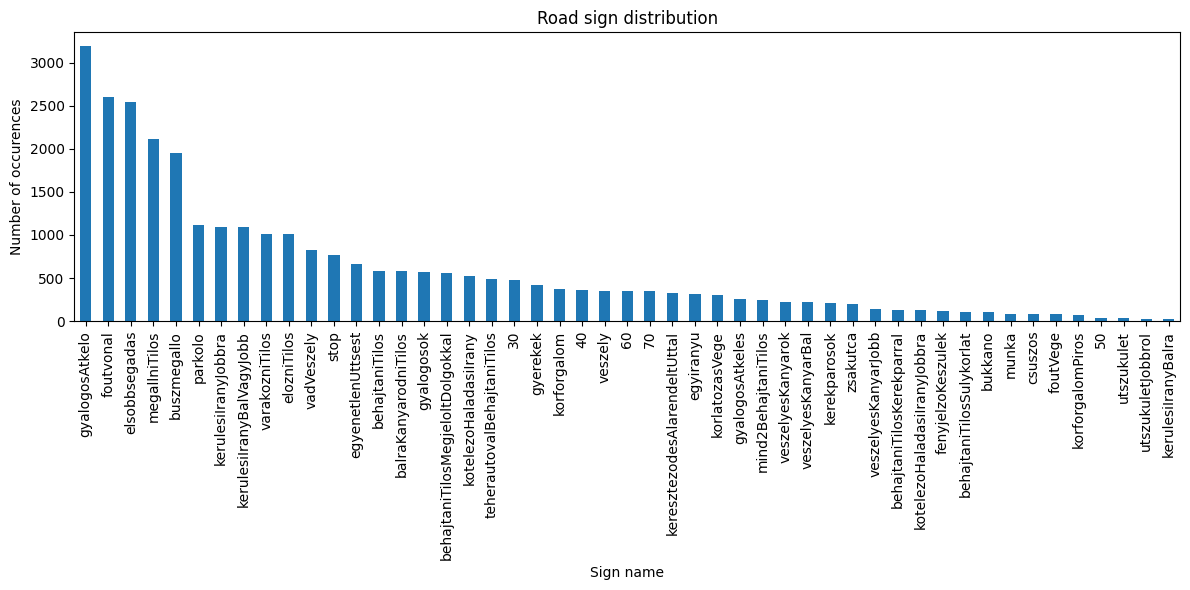

In [ ]:
# Traffic sign distribution

df = pd.read_csv(labels_csv_path)

label_counts = df.drop(columns=["filename", "nincs"]).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Road sign distribution")
plt.xlabel("Sign name")
plt.ylabel("Number of occurences")
plt.tight_layout()
plt.show()


## Training dataset construction

In [10]:
filtered_df = pd.read_csv(filtered_path)

In [11]:
labels_df = pd.read_csv(labels_csv_path)

In [12]:
# Loading dataset
image_paths = [str(multi_label_dir) + "/" + fname for fname in filtered_df["filename"]]
labels = filtered_df.drop(columns=["filename"]).values.astype("float32")

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = image / 255.0
    return image, label

In [13]:
# tf.data.Dataset construction
tf_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

tf_dataset = tf_dataset.map(
    load_image, num_parallel_calls=DATA_AUTOTUNE
)
tf_dataset = tf_dataset.shuffle(
    buffer_size=buffer_size, seed=SEED
)

In [14]:
# Splitting Train/Val
total_size = len(image_paths)
train_size = int(total_size * 0.8)

train_ds = tf_dataset.take(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)
val_ds = tf_dataset.skip(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)

# Sign names 
sign_names = filtered_df.columns.drop("filename").tolist()

print(f"Dataset loaded. Number if images: {total_size}")

Dataset loaded. Number if images: 22542


## Model construction

In [15]:
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, expansion_factor=2, bias=True, dim=-1, **kwargs):
        """
        SwiGLU Activation Layer that automatically adapts to input dimensions
        
        Args:
            expansion_factor: Factor by which to expand the input dimensions (default: 2)
            bias: Whether to use bias in the projection
            dim: The dimension to split on
        """
        super(SwiGLU, self).__init__(**kwargs)
        self.expansion_factor = expansion_factor
        self.bias = bias
        self.dim = dim
        self.dense = None  # Will be initialized on first call
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Create a dense layer that projects to expansion_factor * input_dim
        self.dense = tf.keras.layers.Dense(
            self.expansion_factor * input_dim, 
            use_bias=self.bias
        )
        super(SwiGLU, self).build(input_shape)
        
    def call(self, x):
        # Project input to higher dimension
        x = self.dense(x)
        
        # Split the projected tensor into two equal parts
        out, gate = tf.split(x, num_or_size_splits=2, axis=self.dim)
        
        # Apply swish activation to the gate and multiply with output
        gate = tf.nn.silu(gate)  # silu is the same as swish
        x = out * gate
        
        return x
        
    def get_config(self):
        config = super(SwiGLU, self).get_config()
        config.update({
            'expansion_factor': self.expansion_factor,
            'bias': self.bias,
            'dim': self.dim
        })
        return config
 

In [ ]:
# OLD [not in use]

base_model = MobileNetV3Large (
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet',
    # ConvNeXt
    pooling='avg',
    # Mobilenet
    # alpha=1.,
    # dropout_rate=0.1
)
base_model.trainable = False

trunk = models.Sequential([
])

# for _ in range(10):
    # trunk.add(layers.Dense(1024, 
                        #    activation=activation_func,
                        #    kernel_initializer=dense_initializer))

model = models.Sequential([
    base_model,
    # layers.GlobalAveragePooling2D(),
    # trunk,
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    #     #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # layers.Dense(
    #     512,
    #     activation=activation_func,
    #     kernel_initializer=dense_initializer,
    #     #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    #     #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    # ),
    # # SwiGLU(),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    
    layers.Dense(
        256, 
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(
        len(sign_names),
         kernel_initializer='glorot_uniform',
        activation='sigmoid'
    )
])

In [16]:
base_model.summary()

NameError: name 'base_model' is not defined

In [ ]:
# New feature_extractor os

feature_extractor = MobileNetV3Large (
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet',
    # ConvNeXt
    pooling='avg',
    # Mobilenet
    alpha=1.,
    dropout_rate=0.1
)
feature_extractor.trainable = False

features = []
targets = []

for images, lbls in train_ds:
    feat = feature_extractor(images)
    features.append(feat.numpy())
    targets.append(lbls.numpy())
for images, lbls in val_ds:
    feat = feature_extractor(images)
    features.append(feat.numpy())
    targets.append(lbls.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(targets, axis=0)

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state=SEED
)


In [ ]:

# trunk = models.Sequential([
# ])

# for _ in range(10):
    # trunk.add(layers.Dense(1024, 
                        #    activation=activation_func,
                        #    kernel_initializer=dense_initializer))


In [ ]:
# Classifier for the extracted features

classifier = models.Sequential([
    # trunk,
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        # kernel_regularizer=tf.keras.regularizers.L1L2(0.0001, 0.0001),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        # kernel_regularizer=tf.keras.regularizers.L1L2(0.0001, 0.0001),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        # kernel_regularizer=tf.keras.regularizers.L1L2(0.0001, 0.0001),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        # kernel_regularizer=tf.keras.regularizers.L1L2(0.0001, 0.0001),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(
        512, 
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(
        256, 
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    # SwiGLU(),
    layers.BatchNormalization(),
    # layers.Dropout(0.2),
    
    layers.Dense(
        len(sign_names),
        kernel_initializer='glorot_uniform', #tf.Constant(0.5),
        bias_initializer='zeros',
        activation='sigmoid'
    )
])


## Training

In [19]:
full_model = models.Sequential([
    feature_extractor,
    classifier
])

In [ ]:
# Fit on features

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    # decay=0.004,
    # use_ema=True,
    epsilon=1e-07
)

classifier.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=[
        "accuracy", # tf.keras.metrics.Accuracy(name='accuracy'),
        # tf.keras.metrics.AUC(name='AUC', multi_label=True),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(50, name='f1', ),
        # tfa.metrics.CohenKappa(num_classes=len(class_names))
    ]
)

In [ ]:
# Callbacks
# Checkpoint and save model at the best "val_recall" value
# Early Stopping

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = f"../mentett_model/best_val_recall_classifier_{exp_name}.keras",
        #chekpoint_path + "//" + exp_name + "//",
        monitor="val_recall",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
        initial_value_threshold=0.8,
    ), 
    # tf.keras.callbacks.TensorBoard(
    #     log_path,
    #     histogram_freq=0,
    #     write_steps_per_second=True,
    #     write_images=False,
    #     profile_batch='10, 15',
    # ), 
    tf.keras.callbacks.EarlyStopping(
         monitor='val_accuracy',
         patience=500,
         mode='max',
         restore_best_weights=True,
         verbose=1
     ),
    #tf.keras.callbacks.Progbar # Logger(),
    
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_recall',
    #     mode='max',
    #     factor=0.5,
    #     patience=2,
    #     min_lr=1e-6
    #     )
]# # # # # # # # # # # # # #

In [ ]:
# OLD Compiling [not in use]

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    # decay=0.004,
    # use_ema=True,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=[
        "accuracy", # tf.keras.metrics.Accuracy(name='accuracy'),
        # tf.keras.metrics.AUC(name='AUC', multi_label=True),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(50, name='f1', ),
        # tfa.metrics.CohenKappa(num_classes=len(class_names))
    ]
)

NameError: name 'model' is not defined

In [ ]:
# OLD Training [not in use]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    validation_freq=1,
    #callbacks=callbacks, 
    # shuffle=True,
    # class_weight=sk_class_weights,
    # use_multiprocessing=False
    # verbose=2
)

Epoch 1/20
329/564 [================>.............] - ETA: 8s - loss: 0.8035 - accuracy: 0.0272 - precision: 0.0244 - recall: 0.5294 - f1: 0.0152

KeyboardInterrupt: 

In [ ]:
# New Training

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
281/282 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.8473 - precision: 0.9471 - recall: 0.9224 - f1: 0.8242
Epoch 1: val_recall did not improve from 0.80000
282/282 [==============================] - 4s 12ms/step - loss: 0.0086 - accuracy: 0.8473 - precision: 0.9471 - recall: 0.9222 - f1: 0.8243 - val_loss: 0.0590 - val_accuracy: 0.5804 - val_precision: 0.6974 - val_recall: 0.6221 - val_f1: 0.5086
Epoch 2/100
278/282 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.8451 - precision: 0.9451 - recall: 0.9229 - f1: 0.8211
Epoch 2: val_recall did not improve from 0.80000
282/282 [==============================] - 3s 12ms/step - loss: 0.0086 - accuracy: 0.8451 - precision: 0.9452 - recall: 0.9226 - f1: 0.8199 - val_loss: 0.0766 - val_accuracy: 0.5207 - val_precision: 0.6500 - val_recall: 0.5240 - val_f1: 0.4609
Epoch 3/100
277/282 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.8474 - precision: 0.9464 - r

In [23]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               492032    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

## Model performance visualization

1/1 [==============================] - 1s 818ms/step


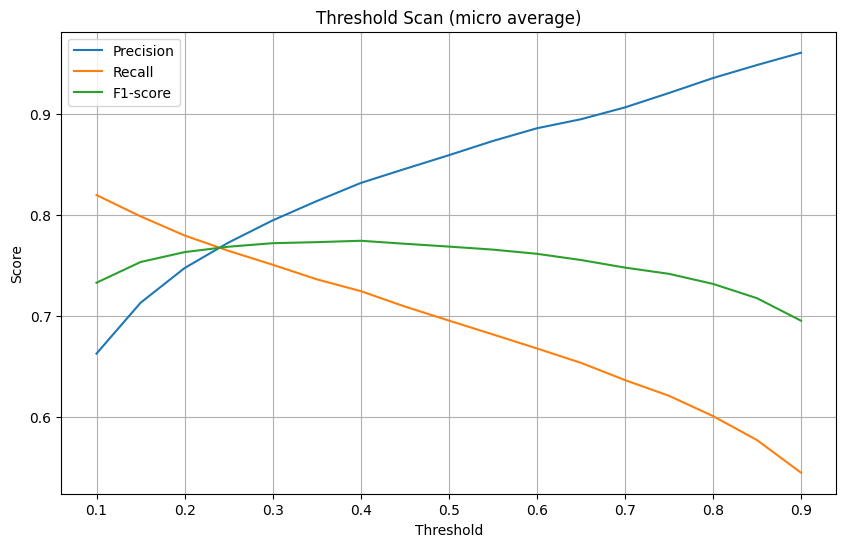

In [ ]:
# Threshold Scan

all_preds = []
all_labels = []

for images, labels in val_ds.unbatch().batch(64):
    preds = model.predict(images)
    all_preds.append(preds)
    all_labels.append(labels.numpy())

y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)

thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_bin = (y_pred > t).astype(int)
    precisions.append(precision_score(y_true, y_pred_bin, average='micro', zero_division=0))
    recalls.append(recall_score(y_true, y_pred_bin, average='micro', zero_division=0))
    f1s.append(f1_score(y_true, y_pred_bin, average='micro', zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Scan (micro average)")
plt.grid(True)
plt.legend()
plt.show()

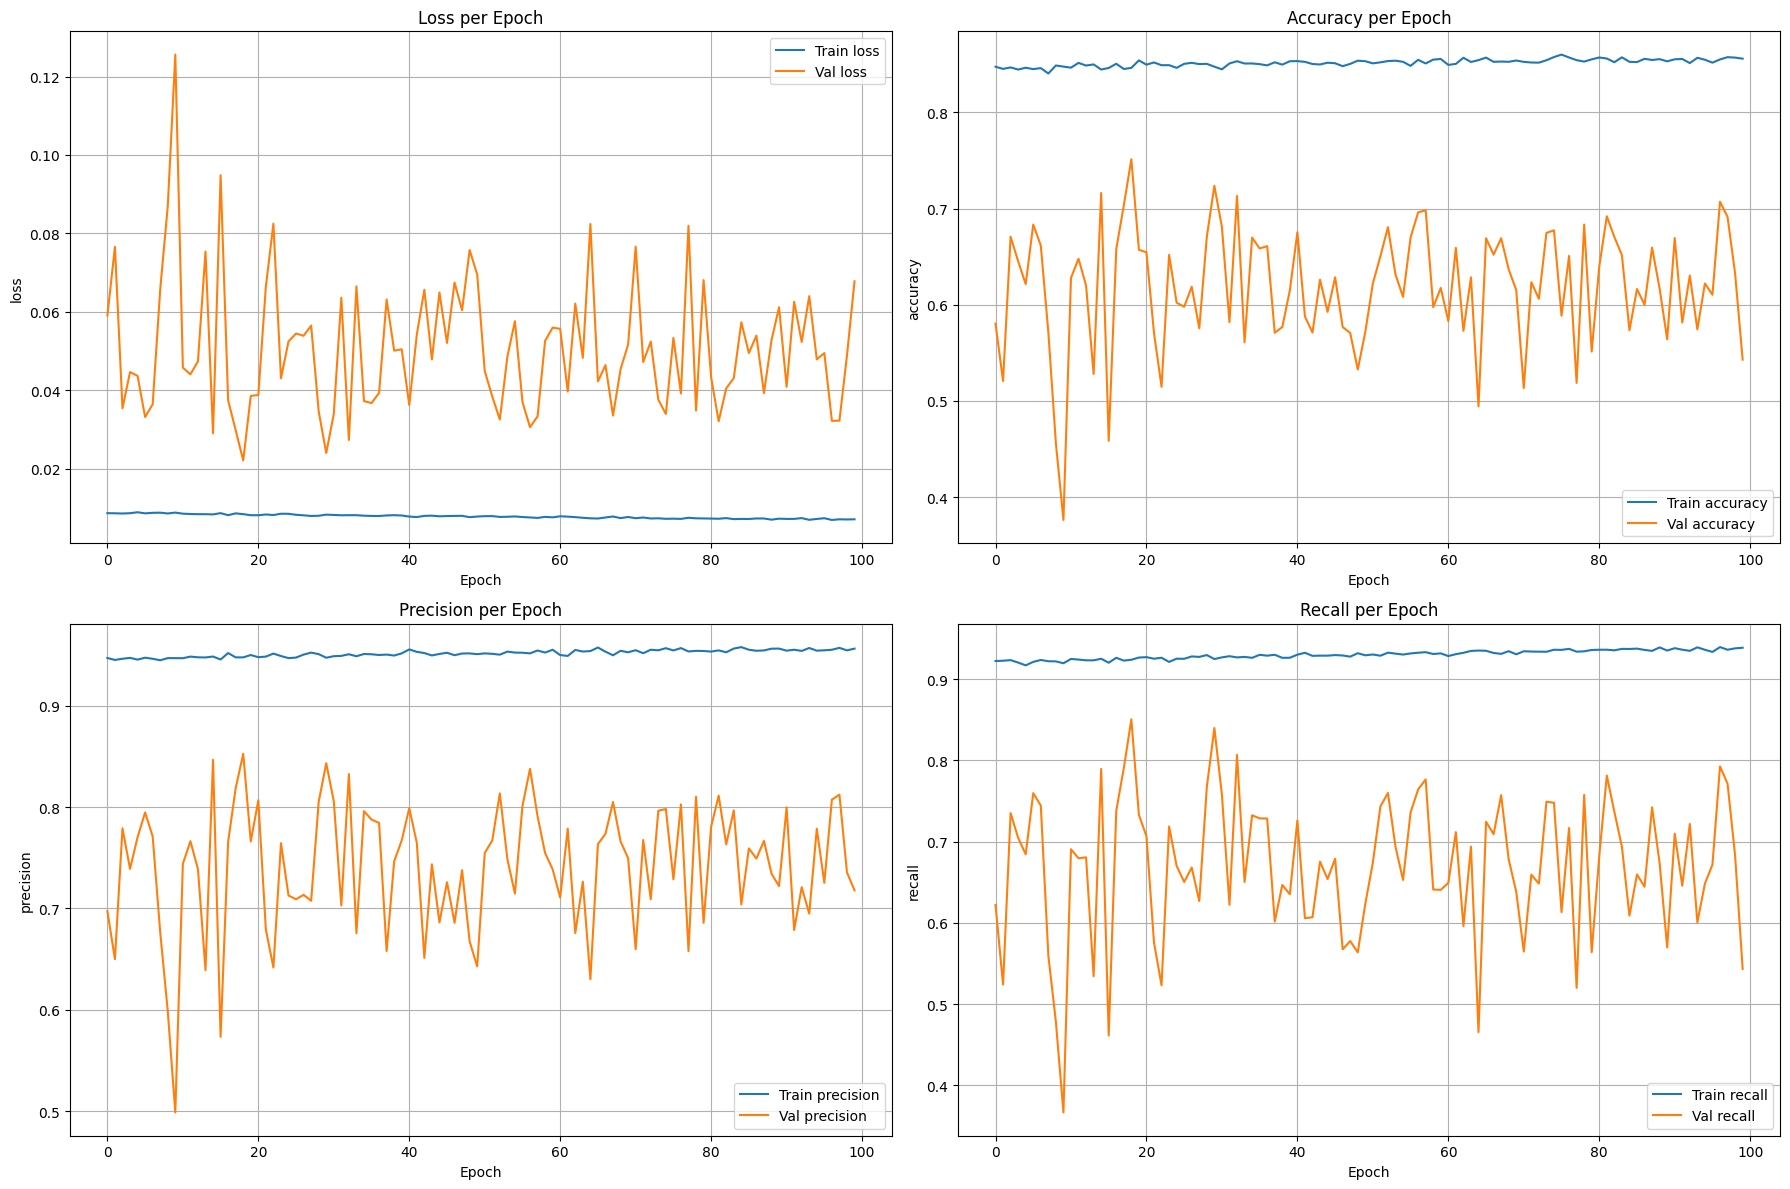

In [ ]:
# Train / Validation graphs

def plot_training_history(history):
    metrics = [
        'loss',
        'accuracy',
        'precision',
        'recall',
    ]

    plt.figure(figsize=(18, 12))
    rows = (len(metrics) + 1) // 2

    for i, metric in enumerate(metrics, 1):
        plt.subplot(rows, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_', ' ').capitalize()} per Epoch")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

In [ ]:
# Load in best classifier
best_classifier = load_model("../mentett_model/best_val_recall_classifier_05_19_2025_15_51.keras", custom_objects={
    'SwiGLU': SwiGLU,
    'F1Score': tfa.metrics.F1Score
})

# Reload pipeline
full_model = tf.keras.Sequential([
    feature_extractor,
    best_classifier
])

# Recompile
full_model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=len(sign_names), name='f1'),
    ]
)

# Save full pipline
full_model.save(f"../mentett_model/full_pipeline_best_val_recall_{exp_name}.keras")


In [ ]:
# Save model as a keras file [not in use]
model.save(f"../mentett_model/model_{exp_name}.keras")

In [118]:
print(model_path)

../mentett_model/full_pipeline_model_05_18_2025_21_34.keras


In [16]:
# Load model
full_model = load_model("../mentett_model/full_pipeline_best_val_recall_05_19_2025_16_58.keras", custom_objects={
    'SwiGLU': SwiGLU,
    'F1Score': tfa.metrics.F1Score
})


In [54]:
full_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 sequential (Sequential)     (None, 50)                1698098   
                                                                 
Total params: 4,694,450
Trainable params: 1,692,466
Non-trainable params: 3,001,984
_________________________________________________________________


In [69]:
# Prediction for 10 random images from MultiLabelFrames

THRESHOLD = 0.7
NUM_SAMPLES = 10

#model = load_model(model_path)
df = pd.read_csv(Path(multi_label_dir) / "labels.csv")
sign_names = df.columns.drop("filename").tolist()

# Select randomly
samples = df.sample(NUM_SAMPLES, random_state=42)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.expand_dims(image / 255.0, axis=0)
    return image

# Predict and show
for _, row in samples.iterrows():
    image_path = str(Path(multi_label_dir) / row["filename"])
    label_vector = row.drop("filename").values.astype("float32")
    true_labels = [sign for sign, val in zip(sign_names, label_vector) if val == 1]

    image = load_image(image_path)
    prediction = full_model.predict(image)[0]
    predicted_labels = [sign for sign, val in zip(sign_names, prediction) if val > THRESHOLD]

    print(f"{row['filename']}")
    print(f"Real labels      : {true_labels}")
    print(f"Model prediction : {predicted_labels}")
    print("-" * 60)


1/1 [==============================] - 0s 15ms/step
0157_24.0_720_nincs.jpg
Real labels      : ['nincs']
Model prediction : ['foutvonal', 'nincs']
------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
0296_59.0_1771.jpg
Real labels      : ['varakozniTilos']
Model prediction : ['varakozniTilos']
------------------------------------------------------------
1/1 [==============================] - 0s 11ms/step
0287_67.5_4051.jpg
Real labels      : ['vadVeszely']
Model prediction : ['vadVeszely']
------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
0294_144.0_4320.jpg
Real labels      : ['gyalogosAtkelo']
Model prediction : ['gyalogosAtkelo']
------------------------------------------------------------
1/1 [==============================] - 0s 21ms/step
0294_74.0_2221.jpg
Real labels      : ['kotelezoHaladasiIrany']
Model prediction : ['kotelezoHaladasiIrany', 'gyalogosAtkel

1/1 [==============================] - 0s 23ms/step
                                  precision    recall  f1-score   support

                              30       0.95      0.96      0.95       386
                              50       0.96      0.69      0.81        36
                              60       0.97      0.92      0.95       267
                              70       0.99      0.75      0.85       330
                     elozniTilos       0.83      0.88      0.85       780
    keresztezodesAlarendeltUttal       0.93      0.95      0.94       294
                       foutvonal       0.81      0.94      0.87      1991
                   elsobbsegadas       0.95      0.98      0.97      2012
                            stop       0.99      0.98      0.99       647
             mind2BehajtaniTilos       0.95      0.97      0.96       108
      teherautovalBehajtaniTilos       0.97      1.00      0.98       291
                  behajtaniTilos       0.99      0.96      

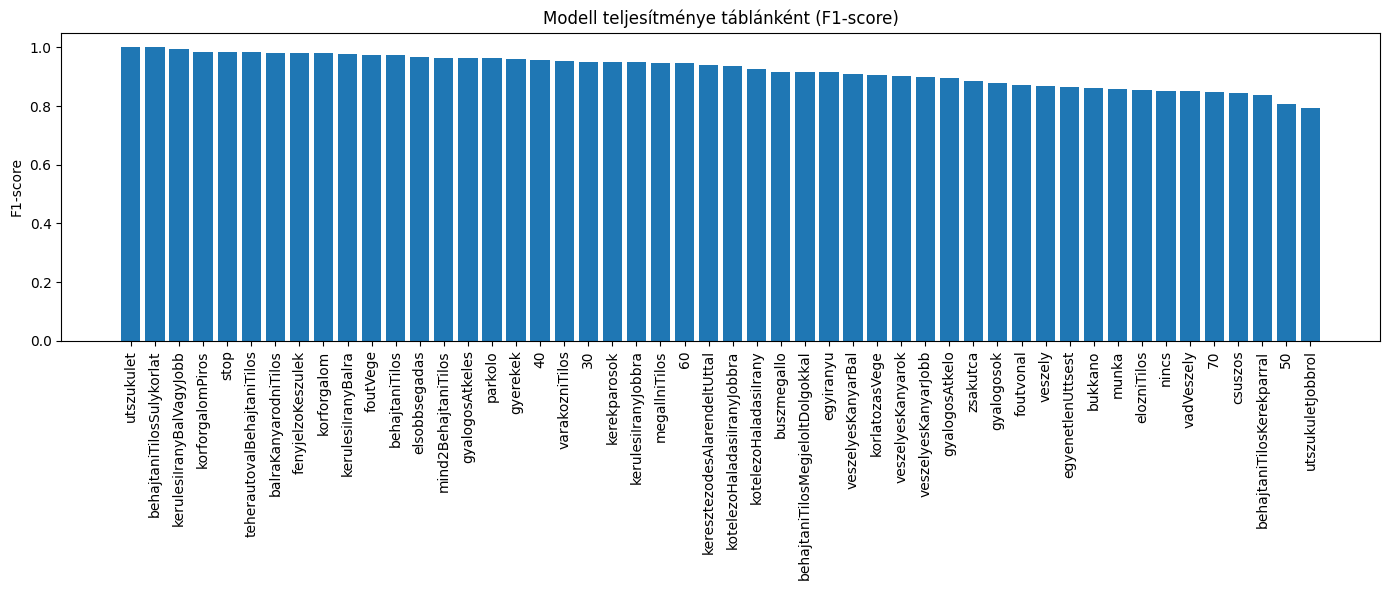

In [ ]:
# F1-score for all road signs

THRESHOLD = 0.4

df = pd.read_csv(filtered_path)
sign_names = df.columns.drop("filename").tolist()
label_map = {name: i for i, name in enumerate(sign_names)}

def gen():
    for _, row in df.iterrows():
        path = str(Path(multi_label_dir) / row["filename"])
        label = row.drop("filename").values.astype("float32")
        yield path, label

def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = image / 255.0
    return image, label

ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(len(sign_names),), dtype=tf.float32)
    )
).map(preprocess).batch(batch_size)

y_true = []
y_pred = []

for images, labels in ds:
    probs = full_model.predict(images)
    preds = (probs > THRESHOLD).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print(classification_report(np.array(y_true), np.array(y_pred), target_names=sign_names, zero_division=0))

report_dict = classification_report(
    np.array(y_true), np.array(y_pred),
    target_names=sign_names,
    zero_division=0,
    output_dict=True
)

f1_scores = {label: metrics["f1-score"] for label, metrics in report_dict.items() if label in sign_names}

f1_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(14, 6))
plt.bar(f1_sorted.keys(), f1_sorted.values())
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("Modell teljesítménye táblánként (F1-score)")
plt.tight_layout()
plt.show()


In [ ]:
# Prediction for videos to CSV files

VIDEO_PATH = Path(video_dir)/"0255.mp4"
OUTPUT_CSV = Path(detections_path)/"0255.csv"
THRESHOLD = 0.8
TIMESTEP = 0.5

label_path = Path("../MultiLabelFrames/labels.csv")
df_labels = pd.read_csv(label_path)
sign_names = df_labels.columns.drop("filename").tolist()

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

timestamps = np.arange(0, duration, TIMESTEP)
results = []

for t in timestamps:
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if not ret:
        results.append([t] + [0] * len(sign_names))
        continue

    frame = cv2.resize(frame, (img_size, img_size))
    image = tf.convert_to_tensor(frame / 255.0, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    preds = full_model.predict(image)[0]
    labels = (preds > THRESHOLD).astype(int).tolist()

    results.append([t] + labels)

cap.release()

df_out = pd.DataFrame(results, columns=["timestamp"] + sign_names)
Path(OUTPUT_CSV).parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(OUTPUT_CSV, index=False)
print("Done:", OUTPUT_CSV)


1/1 [==============================] - 0s 27ms/step


In [ ]:
# Visual representation for the predictions

VIDEO_PATH = Path(video_dir)/"0255.mp4"
CSV_PATH = Path(detections_path)/"0255.csv"
IMG_SIZE = (1440, 900)

df = pd.read_csv(CSV_PATH)
columns = df.columns.tolist()
timestamp_col = columns[0]
label_cols = columns[1:]

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# User Interface
class PredictionViewer:
    def __init__(self, root):
        self.root = root
        self.root.title("Model prediction")

        self.canvas = tk.Canvas(root, width=IMG_SIZE[0], height=IMG_SIZE[1])
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.info_label = tk.Label(root, text="", font=("Arial", 12), justify="left")
        self.info_label.grid(row=1, column=0, columnspan=3, pady=10)

        self.back_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.back_btn.grid(row=2, column=0)

        self.forward_btn = tk.Button(root, text="Next >>", command=self.next_frame)
        self.forward_btn.grid(row=2, column=2)

        self.frame_index = 0
        self.update_frame()

    def update_frame(self):
        row = df.iloc[self.frame_index]
        timestamp = row[timestamp_col]
        cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = cap.read()
        if not ret:
            return
        frame = cv2.resize(frame, IMG_SIZE)
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        detected = [name for name in label_cols if row[name] == 1]
        text = f"Idő: {timestamp:.1f} s\nFelismert táblák: {', '.join(detected) if detected else 'nincs'}"
        self.info_label.config(text=text)

    def next_frame(self):
        if self.frame_index + 1 < len(df):
            self.frame_index += 1
            self.update_frame()

    def prev_frame(self):
        if self.frame_index > 0:
            self.frame_index -= 1
            self.update_frame()

In [ ]:
# Launch user interface
if __name__ == "__main__":
    root = tk.Tk()
    app = PredictionViewer(root)
    root.mainloop()